In [16]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import DatasetMaker

import neural_tangents as nt
from neural_tangents import stax
import jax
import jax.numpy as jnp

In [17]:
import os
import pickle

import os
import numpy as np
import torch
import random
import pickle
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from scipy.stats import linregress


In [18]:
import importlib
importlib.reload(DatasetMaker)

<module 'DatasetMaker' from '/n/home07/bruben/Simulations/Ensemble_DeepLearning/RandomFeatures/DatasetMaker.py'>

In [19]:
# Code cell to compute and save the full kernel matrix K_train_train in tiles

def compute_and_save_full_kernel_matrix(X_train_np, kernel_fn, tile_size, kernel_dir):
    N_train = X_train_np.shape[0]
    NUM_TILES = int(np.ceil(N_train / tile_size))
    for i in range(NUM_TILES):
        for j in range(i, NUM_TILES):
            tile_file = os.path.join(kernel_dir, f"kernel_tile_{i}_{j}.npy")
            if os.path.exists(tile_file):
                print(f"Tile ({i}, {j}) already exists. Skipping.")
                continue
            else:
                print(f"Computing tile ({i}, {j})")
                start_i = i * tile_size
                end_i = min((i+1)*tile_size, N_train)
                start_j = j * tile_size
                end_j = min((j+1)*tile_size, N_train)
                X_i = X_train_np[start_i:end_i]
                X_j = X_train_np[start_j:end_j]
                K_tile = kernel_fn(X_i, X_j, get='nngp')
                K_tile = np.array(K_tile)
                np.save(tile_file, K_tile)
    print("Finished computing and saving all tiles.")


In [20]:
# Code cell to compute and save K_test_train

def compute_and_save_test_train_kernel_matrix(X_test_np, X_train_np, kernel_fn, tile_size, kernel_dir):
    N_train = X_train_np.shape[0]
    N_test = X_test_np.shape[0]
    NUM_TRAIN_TILES = int(np.ceil(N_train / tile_size))
    K_test_train = []
    for j in range(NUM_TRAIN_TILES):
        tile_file = os.path.join(kernel_dir, f"kernel_test_train_tile_{j}.npy")
        if os.path.exists(tile_file):
            print(f"Tile ({j}) already exists. Loading.")
            K_tile = np.load(tile_file)
        else:
            print(f"Computing tile ({j})")
            start_j = j * tile_size
            end_j = min((j+1)*tile_size, N_train)
            X_train_j = X_train_np[start_j:end_j]
            K_tile = kernel_fn(X_test_np, X_train_j, get='nngp')
            K_tile = np.array(K_tile)
            np.save(tile_file, K_tile)
        K_test_train.append(K_tile)
    K_test_train = np.hstack(K_test_train)
    # Optionally save K_test_train as a single file
    K_test_train_file = os.path.join(kernel_dir, "K_test_train.npy")
    np.save(K_test_train_file, K_test_train)
    print("Finished computing and saving K_test_train.")

In [21]:
# Code cell for get_kernel_subset()

def get_kernel_subset(indices, tile_size, kernel_dir):
    indices = np.array(indices)
    N_train = max(indices) + 1
    NUM_TILES = int(np.ceil(N_train / tile_size))
    n = len(indices)
    K_subset = np.zeros((n, n), dtype=np.float32)
    index_map = {idx: pos for pos, idx in enumerate(indices)}
    for i in range(NUM_TILES):
        start_i = i * tile_size
        end_i = min((i+1)*tile_size, N_train)
        indices_i = [idx for idx in indices if start_i <= idx < end_i]
        if not indices_i:
            continue
        for j in range(i, NUM_TILES):
            start_j = j * tile_size
            end_j = min((j+1)*tile_size, N_train)
            indices_j = [idx for idx in indices if start_j <= idx < end_j]
            if not indices_j:
                continue
            # Load the tile
            tile_file = os.path.join(kernel_dir, f"kernel_tile_{i}_{j}.npy")
            K_tile = np.load(tile_file)
            # Map indices to positions in K_tile
            idx_i_in_tile = [idx - start_i for idx in indices_i]
            idx_j_in_tile = [idx - start_j for idx in indices_j]
            # Get positions in K_subset
            pos_i_in_K = [index_map[idx] for idx in indices_i]
            pos_j_in_K = [index_map[idx] for idx in indices_j]
            # Get submatrix
            K_tile_subset = K_tile[np.ix_(idx_i_in_tile, idx_j_in_tile)]
            # Since K is symmetric, fill both K_subset and its transpose if i != j
            K_subset[np.ix_(pos_i_in_K, pos_j_in_K)] = K_tile_subset
            if i != j:
                K_subset[np.ix_(pos_j_in_K, pos_i_in_K)] = K_tile_subset.T
    return K_subset


In [22]:
# Code cell for get_kernel_test_subset()

def get_kernel_test_subset(train_indices, kernel_dir):
    # Load K_test_train
    K_test_train_file = os.path.join(kernel_dir, "K_test_train.npy")
    K_test_train = np.load(K_test_train_file)
    # Extract the columns corresponding to train_indices
    K_test_subset = K_test_train[:, train_indices]
    return K_test_subset

In [23]:
# Function to get the dataset
def load_data(data_root, class_groups):
    # Load the CIFAR10 data
    X_train_np, y_train_np, X_test_np, y_test_np = DatasetMaker.get_binarized_CIFAR10(
        data_root, class_groups, flatten=True, normalize=True)
    # Ensure test data is in the correct format
    X_test_np = X_test_np.astype(np.float32)
    y_test_np = y_test_np.reshape(-1, 1).astype(np.float32)
    return X_train_np, y_train_np, X_test_np, y_test_np

# Function to set up directories
def setup_dirs(base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    return base_dir

# Function to get the NNGP kernel function
def get_nngp_kernel_fn(depth=1):
    width = 1  # Width is irrelevant for kernel computation
    layers = []
    for _ in range(depth):
        layers += [stax.Dense(width, W_std=np.sqrt(2), b_std=0.0), stax.Relu()]
    layers += [stax.Dense(1, W_std=1.0, b_std=0.0)]
    _, _, kernel_fn = stax.serial(*layers)
    return kernel_fn

# Modified compute_kernel_matrix()

def compute_kernel_matrix(indices, tile_size, kernel_dir):
    K_subset = get_kernel_subset(indices, tile_size, kernel_dir)
    return K_subset

# Modified compute_trace_and_mse()

def compute_trace_and_mse(K_subset, y_train_subset, train_indices, y_test_np, lambda_reg, device, kernel_dir):
    # Convert to PyTorch tensors
    K_subset_torch = torch.from_numpy(K_subset).to(device).float()
    y_train_subset_torch = torch.from_numpy(y_train_subset).to(device).float()
    y_test_torch = torch.from_numpy(y_test_np).to(device).float()

    # Regularize kernel and invert
    n = K_subset_torch.shape[0]
    K_reg = K_subset_torch + lambda_reg * torch.eye(n, device=device).float()
    K_inv = torch.inverse(K_reg)
    trace_K_inv = torch.trace(K_inv).item()

    # Trace metric
    trace_metric = 1.0 / trace_K_inv

    # Kernel Ridge Regression (KRR) alpha = (K + λI)^(-1) y
    alpha = K_inv @ y_train_subset_torch

    # Compute K_test_subset
    K_test_subset = get_kernel_test_subset(train_indices, kernel_dir)
    K_test_subset_torch = torch.from_numpy(K_test_subset).to(device).float()

    # Predict on the test set
    y_pred = K_test_subset_torch @ alpha

    # Compute MSE
    mse = torch.mean((y_pred - y_test_torch) ** 2).item()
    
    del K_test_subset_torch, K_subset_torch, y_test_torch, y_train_subset_torch

    return trace_metric, mse

# Modified perform_trials()

def perform_trials(X_train_np, y_train_np, y_test_np, subset_sizes, num_trials, lambda_reg, device, kernel_dir, save_dir, tile_size):
    for trial in range(num_trials):
        print(f'Starting Trial {trial + 1}/{num_trials}')
        for subset_size in subset_sizes:
            print(f'Trial {trial + 1}/{num_trials} | Subset size: {subset_size}')
            # Check if results for this trial and subset size already exist
            trial_file = os.path.join(save_dir, f'trial_{trial}_subset_{subset_size}.pkl')
            if os.path.exists(trial_file):
                print(f'Results for Trial {trial + 1}, Subset size {subset_size} already exist. Skipping.')
                continue  # Skip to next iteration
            else:
                # Randomly sample the subset
                indices = random.sample(range(X_train_np.shape[0]), subset_size)
                indices.sort()
                y_train_subset = y_train_np[indices].reshape(-1, 1)

                # Compute kernel matrix
                K_subset = compute_kernel_matrix(indices, tile_size, kernel_dir)

                # Compute trace metric and MSE
                trace_metric, mse = compute_trace_and_mse(K_subset, y_train_subset, indices, y_test_np, lambda_reg, device, kernel_dir)

                # Save trial results
                result_data = {
                    'trace_metric': trace_metric,
                    'mse': mse
                }
                with open(trial_file, 'wb') as f:
                    pickle.dump(result_data, f)
                print(f'Saved results for Trial {trial + 1}, Subset size {subset_size}')

# Function to load all trial results
def load_all_trial_results(subset_sizes, save_dir):
    # Initialize lists to store metrics from all trials
    all_trace_metrics = []
    all_mse_errors = []

    # Find all trial files
    trial_files = [f for f in os.listdir(save_dir) if f.endswith('.pkl')]
    # Get the list of trial numbers
    trial_numbers = set()
    for f in trial_files:
        parts = f.split('_')
        if len(parts) >= 4 and parts[0] == 'trial' and parts[2] == 'subset':
            trial_numbers.add(int(parts[1]))
    trial_numbers = sorted(trial_numbers)

    # For each trial, collect the metrics
    for trial in trial_numbers:
        trace_metrics_trial = []
        mse_errors_trial = []
        for subset_size in subset_sizes:
            trial_file = os.path.join(save_dir, f'trial_{trial}_subset_{subset_size}.pkl')
            if os.path.exists(trial_file):
                with open(trial_file, 'rb') as f:
                    result_data = pickle.load(f)
                trace_metric = result_data['trace_metric']
                mse = result_data['mse']
                trace_metrics_trial.append(trace_metric)
                mse_errors_trial.append(mse)
            else:
                print(f'Warning: Missing data for Trial {trial + 1}, Subset size {subset_size}')
                trace_metrics_trial.append(None)
                mse_errors_trial.append(None)
        all_trace_metrics.append(trace_metrics_trial)
        all_mse_errors.append(mse_errors_trial)
    return all_trace_metrics, all_mse_errors

# Function to average results across trials
def average_results(subset_sizes, save_dir):
    all_trace_metrics, all_mse_errors = load_all_trial_results(subset_sizes, save_dir)
    num_trials = len(all_trace_metrics)

    trace_metrics_mean = []
    trace_metrics_std = []
    mse_errors_mean = []
    mse_errors_std = []

    for i in range(len(subset_sizes)):
        # Collect the metrics for this subset size across all trials
        trace_metrics_i = [all_trace_metrics[trial][i] for trial in range(num_trials) if all_trace_metrics[trial][i] is not None]
        mse_errors_i = [all_mse_errors[trial][i] for trial in range(num_trials) if all_mse_errors[trial][i] is not None]
        # Compute mean and std
        trace_metrics_mean.append(np.mean(trace_metrics_i))
        trace_metrics_std.append(np.std(trace_metrics_i))
        mse_errors_mean.append(np.mean(mse_errors_i))
        mse_errors_std.append(np.std(mse_errors_i))

    return trace_metrics_mean, trace_metrics_std, mse_errors_mean, mse_errors_std

# Function to plot results
def plot_results(subset_sizes, trace_metrics_mean, trace_metrics_std, mse_errors_mean, mse_errors_std, save_dir, ignore_first_n = 0):
    figure_width = 3.5  # Width in inches
    figure_height = 2.5  # Height in inches

    # Convert subset_sizes to numpy array
    subset_sizes_array = np.array(subset_sizes)[ignore_first_n:]
    trace_metrics_mean = np.array(trace_metrics_mean)[ignore_first_n:]
    trace_metrics_std = np.array(trace_metrics_std)[ignore_first_n:]
    mse_errors_mean = np.array(mse_errors_mean)[ignore_first_n:]
    mse_errors_std = np.array(mse_errors_std)[ignore_first_n:]

    # Set plotting parameters for smaller publication-quality plots
    plt.rcParams.update({
        'font.size': 10,          # Font size for labels
        'legend.fontsize': 8,     # Font size for legends
        'axes.labelsize': 12,     # Font size for axis labels
        'axes.titlesize': 14,     # Font size for title
        'xtick.labelsize': 10,    # Font size for x-tick labels
        'ytick.labelsize': 10,    # Font size for y-tick labels
        'lines.linewidth': 1.5,   # Line width for plots
        'lines.markersize': 5,    # Marker size
        'figure.dpi': 300         # Dots per inch for high-resolution images
    })

    # Plot the trace metric as a function of subset size
    plt.figure(figsize=(figure_width, figure_height))
    plt.errorbar(subset_sizes_array, trace_metrics_mean, yerr=trace_metrics_std, fmt='o', color='blue', label='Trace Metric')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Subset Size n')
    plt.ylabel(r'$(\mathrm{Tr}[K_n^{-1}])^{-1}$')
    plt.title('Trace Metric vs Subset Size')
    plt.grid(True, which='both', linestyle='--')

    # Fit to power law: trace_metric ~ n^{-alpha}
    log_n = np.log(subset_sizes_array)
    log_trace_metric = np.log(trace_metrics_mean)
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_trace_metric)
    alpha_estimated = -slope
    print(f'Estimated alpha: {alpha_estimated:.4f}')

    # Plot fitted line
    fitted_trace_metric = np.exp(intercept) * subset_sizes_array ** slope
    plt.plot(subset_sizes_array, fitted_trace_metric, 'r--', label=f'Fit α={alpha_estimated:.2f}')
    plt.legend()

    # Save the figure with a descriptive filename
    plt.savefig(os.path.join(save_dir, 'Trace_Metric_vs_Subset_Size.svg'), bbox_inches='tight', transparent = True)

    # Plot the MSE as a function of subset size
    plt.figure(figsize=(figure_width, figure_height))
    plt.errorbar(subset_sizes_array, mse_errors_mean, yerr=mse_errors_std, fmt='o', color='green', label='MSE on Test Set')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Subset Size n')
    plt.ylabel('Mean Squared Error')
    plt.title('Test MSE vs Subset Size')
    plt.grid(True, which='both', linestyle='--')

    # Fit to power law: MSE ~ n^{-beta}
    log_mse = np.log(mse_errors_mean)
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_mse)
    beta_estimated = -slope
    print(f'Estimated beta: {beta_estimated:.4f}')

    # Plot fitted line
    fitted_mse = np.exp(intercept) * subset_sizes_array ** slope
    plt.plot(subset_sizes_array, fitted_mse, 'r--', label=f'Fit β={beta_estimated:.2f}')
    plt.legend()

    # Save the figure with a descriptive filename
    plt.savefig(os.path.join(save_dir, 'MSE_vs_Subset_Size.svg'), bbox_inches='tight', transparent = True)

    # Show the plots
    plt.show()

In [24]:
# Main script
data_root = '/n/holystore01/LABS/pehlevan_lab/Everyone/cifar'
class_groups =  [[0,1,7,8,9], [2,3,4,5,6]]

# Load the data
X_train_np, y_train_np, X_test_np, y_test_np = load_data(data_root, class_groups)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
kernel_dir = '/n/holystore01/LABS/pehlevan_lab/Lab/bruben/Ensemble_Random_Features/CIFAR_NNGP_Kernel'
# Define kernel and other parameters
lambda_reg = 1e-6
save_dir = setup_dirs('KernelFitting_cifar')
kernel_fn = get_nngp_kernel_fn(depth=1)
kernel_fn = nt.batch(kernel_fn, batch_size=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [26]:
# Set the tile size
tile_size = 10000

# Compute and save the full kernel matrix K_train_train in tiles
compute_and_save_full_kernel_matrix(X_train_np, kernel_fn, tile_size, kernel_dir)

Tile (0, 0) already exists. Skipping.
Tile (0, 1) already exists. Skipping.
Tile (0, 2) already exists. Skipping.
Tile (0, 3) already exists. Skipping.
Tile (0, 4) already exists. Skipping.
Tile (1, 1) already exists. Skipping.
Tile (1, 2) already exists. Skipping.
Tile (1, 3) already exists. Skipping.
Tile (1, 4) already exists. Skipping.
Tile (2, 2) already exists. Skipping.
Tile (2, 3) already exists. Skipping.
Tile (2, 4) already exists. Skipping.
Tile (3, 3) already exists. Skipping.
Tile (3, 4) already exists. Skipping.
Tile (4, 4) already exists. Skipping.
Finished computing and saving all tiles.


In [27]:
# Compute and save K_test_train
compute_and_save_test_train_kernel_matrix(X_test_np, X_train_np, kernel_fn, tile_size, kernel_dir)

Tile (0) already exists. Loading.
Tile (1) already exists. Loading.
Tile (2) already exists. Loading.
Tile (3) already exists. Loading.
Tile (4) already exists. Loading.
Finished computing and saving K_test_train.


In [28]:
# Set the subset sizes and number of trials
subset_sizes = [int(round(i, -1)) for i in np.logspace(3, np.log10(20000), 21)]  # Adjust as needed
num_trials = 10  # Number of trials

In [29]:
# Cell 6: Run the trials using precomputed kernels
perform_trials(X_train_np, y_train_np, y_test_np,
               subset_sizes, num_trials,
               lambda_reg, device, kernel_dir, save_dir, tile_size)

Starting Trial 1/10
Trial 1/10 | Subset size: 1000
Saved results for Trial 1, Subset size 1000
Trial 1/10 | Subset size: 1160
Saved results for Trial 1, Subset size 1160
Trial 1/10 | Subset size: 1350
Saved results for Trial 1, Subset size 1350
Trial 1/10 | Subset size: 1570
Saved results for Trial 1, Subset size 1570
Trial 1/10 | Subset size: 1820
Saved results for Trial 1, Subset size 1820
Trial 1/10 | Subset size: 2110
Saved results for Trial 1, Subset size 2110
Trial 1/10 | Subset size: 2460
Saved results for Trial 1, Subset size 2460
Trial 1/10 | Subset size: 2850
Saved results for Trial 1, Subset size 2850
Trial 1/10 | Subset size: 3310
Saved results for Trial 1, Subset size 3310
Trial 1/10 | Subset size: 3850
Saved results for Trial 1, Subset size 3850
Trial 1/10 | Subset size: 4470
Saved results for Trial 1, Subset size 4470
Trial 1/10 | Subset size: 5190
Saved results for Trial 1, Subset size 5190
Trial 1/10 | Subset size: 6030
Saved results for Trial 1, Subset size 6030
Trial

Estimated alpha: 1.4152
Estimated beta: 0.0822


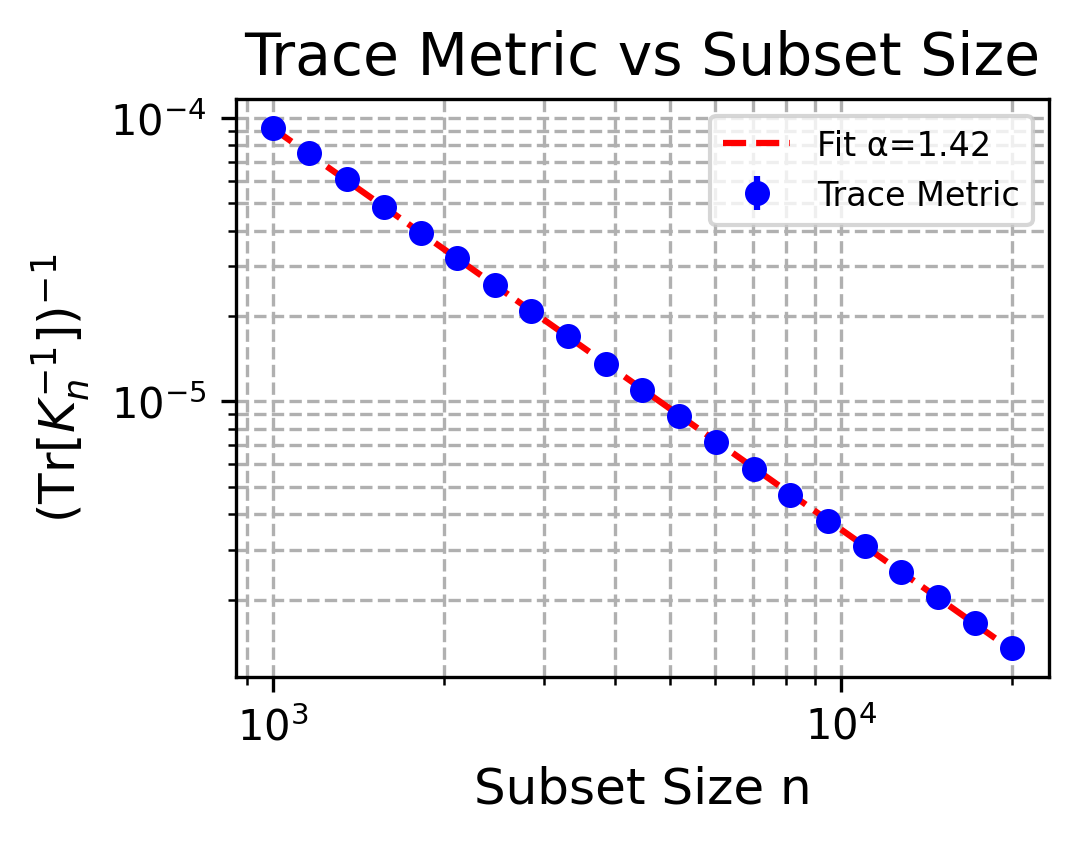

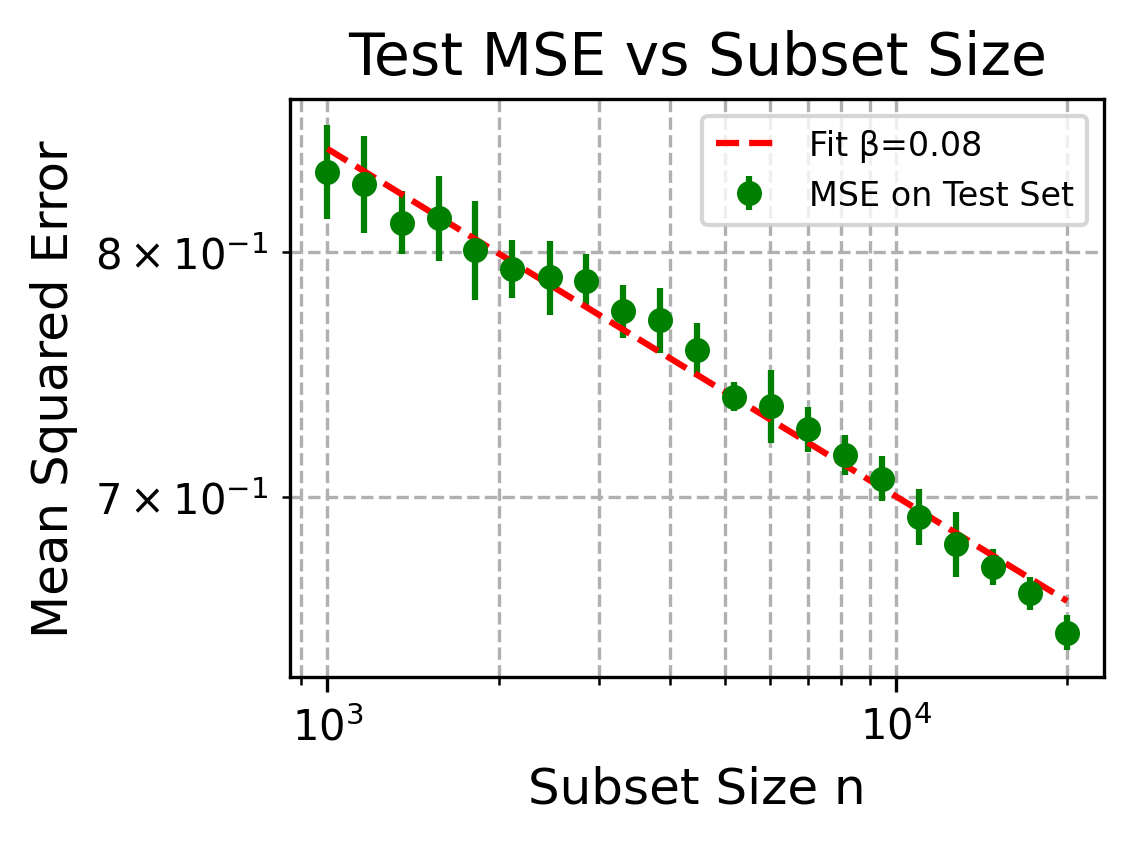

In [30]:
# Load all trial results and average them
trace_metrics_mean, trace_metrics_std, mse_errors_mean, mse_errors_std = average_results(subset_sizes, save_dir)

# Plot the averaged results with power-law fitting and error bars
plot_results(subset_sizes, trace_metrics_mean, trace_metrics_std, mse_errors_mean, mse_errors_std, save_dir)